# Домашнее задание 5

Это домашнее задание по материалам второго семинаров. Дедлайн по отправке - 23:55 17 марта. 

Домашнее задание выполняется в этом же Jupyter Notebook'e и присылается мне на почту: __beznosikov.an@phystech.edu__.

Решение каждой задачи необходимо поместить после её условия.

Файл должен называться: Фамилия_Имя_Optimization_HW_5

При полном запуске Вашего решения (Kernel -> Restart & Run All) все ячейки должны выполняться без ошибок. 

## Задача 1

Рассмотрим задачу минимизации:
\begin{equation}
\min_{x \in \mathbb{R}^d} f(x) = \frac{1}{2}x^T A x - b^T x,
\end{equation}
где в качестве матрицы $A$ - случайная матрица с $L =1000$, $\mu = 1$, $d = 100$, $b$ - так же случайный вектор.

__(а)__ Для такой задачи симулируем итерацию SGD:
$$
x^{k+1} = x^k - \gamma (\nabla f(x^k) + \xi^k),
$$
где $\xi^k$ - независимая от $x^k$ случайная величина из нормального распределения $\mathcal{N}(0, 100)$.

Для такого метода с $\gamma = \frac{1}{L}$ постройте график сходимости (критерий $\| \nabla f(x^k)\|^2$). Постройте на этом же графике сходимость честного градиентного спуска c $\gamma = \frac{1}{L}$. Сделайте вывод о характере сходимости нового метода.

In [6]:
import numpy as np
import scipy.linalg as la
import math
import matplotlib.pyplot as plt
import time

In [176]:
# m >= 0, L >= m
def generate(d = 3, m = 1, L = 5):

    # сгенерируем диагональную матрицу по собственным числам
    if d == 1:
        lambdas = [m]
    if d == 2:
        lambdas = [m, L]
    if d > 2:
        lambdas = np.random.uniform(low=m, high=L, size=(d-2,))
        lambdas = lambdas.tolist() + [m, L]

    A = np.diag(lambdas)
    q, _ = la.qr(np.random.rand(d, d))
    A = q.T @ A @ q
    b = np.random.uniform(low=-L/10, high=L/10, size=(d,))

    return A, b

In [177]:
d = 100
mu = 1
L = 1000
A, b = generate(d, mu, L)

In [178]:
def f(x):
    return 0.5 * x.T @ A @ x - b.T @ x

def grad(x):
    return A @ x - b

In [179]:
x0 = np.random.uniform(low=-L/20, high=L/20, size=(d,))

def gamma_const(x, k):
    return 1/L

def gamma_lin(x, k):
    return 2/(k+L)

In [180]:
def err_gradnorm(x):
    return np.linalg.norm(grad(x), ord=2)**2

def sgd_step1(x, k, gamma, b):
    xi = np.zeros(d)
    for i in range(b):
        xi += np.random.normal(loc=0., scale=100., size=(1, d))[0]
    xi = xi/b
    return x - gamma(x, k) * (grad(x) - xi)

def gd_step(x, k, gamma, b):
    return x - gamma(x, k) * grad(x)

In [181]:
def method(x0, step, gamma=gamma_const, error=err_gradnorm, b=1, iters=1000, eps=1e-9):
    x = x0
    x_vals = [x]
    f_vals = [f(x)]
    times = [0.]
    errs = [error(x)]

    start = time.time()

    for i in range(1, iters):
        x = step(x, i, gamma, b)

        x_vals.append(x)
        f_vals.append(f(x))
        times.append(time.time() - start)
        errs.append(error(x))

        if error(x) < eps:
            break

    return x_vals, f_vals, times, errs

In [182]:
iters = 2000
x1, f1, times1, errs1 = method(x0, step=sgd_step1, gamma=gamma_const, b=1, iters=iters)

In [12]:
def risovach(times, errs, labels):

    plt.figure(figsize=(9, 6))
    for g, l in zip(errs, labels):
        plt.plot(range(len(g)), np.log(g), label=l)
    plt.xlabel("Номер итерации")
    plt.ylabel("Логарифм критерия")
    plt.title('График по итерациям')
    plt.legend(fontsize=12)
    plt.show()

    plt.figure(figsize=(9, 6))
    for t, g, l in zip(times, errs, labels):
        plt.plot(t, np.log(g), label=l)
    plt.xlabel("Прошедшее время")
    plt.ylabel("Логарифм критерия")
    plt.title('График по времени')
    plt.legend(fontsize=12)
    plt.show()

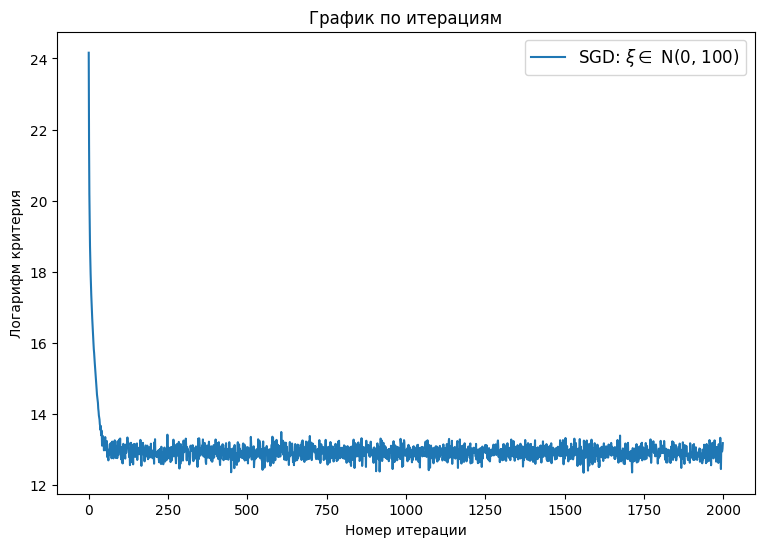

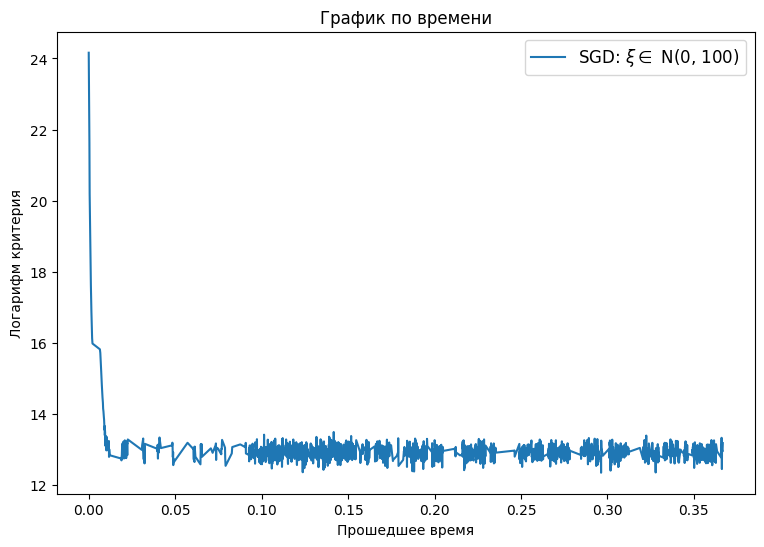

In [184]:
risovach(times=[times1], errs=[errs1], labels=[r'SGD: $\xi \in$ N(0, 100)'])

Со временем норма градиента уменьшается, а $\xi$ всё так же распределенная величина: с какого-то момента эта стохастичность перебивает градиент и метод в среднем топчется на месте. Я бы попробовал следующие пути решения: уменьшать $\gamma$ со временем или уменьшать лишь $\xi$. Попробуем реализовать вторую стратегию.

In [185]:
x2, f2, times2, errs2 = method(x0, step=sgd_step1, gamma=gamma_lin, b=1, iters=iters)

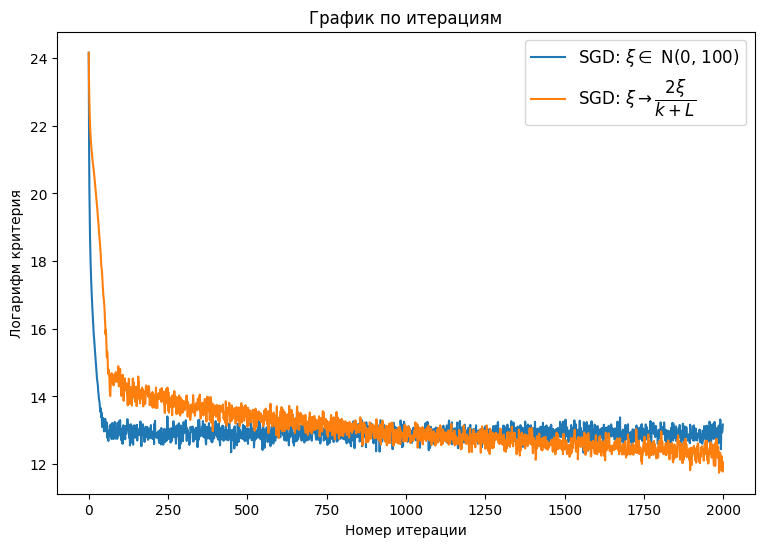

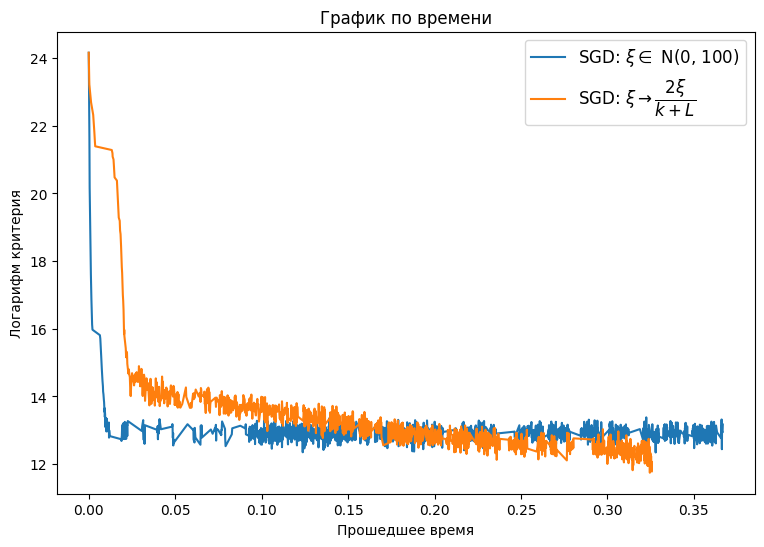

In [186]:
risovach(times=[times1, times2], errs=[errs1, errs2], labels=[r'SGD: $\xi \in$ N(0, 100)', r'SGD: $\xi \rightarrow \dfrac{2\xi}{k+L}$'])

Гипотеза подтвердилась. Сравним оба подхода с базовым градиентным спуском.

In [187]:
x3, f3, times3, errs3 = method(x0, step=gd_step, gamma=gamma_const, iters=iters)

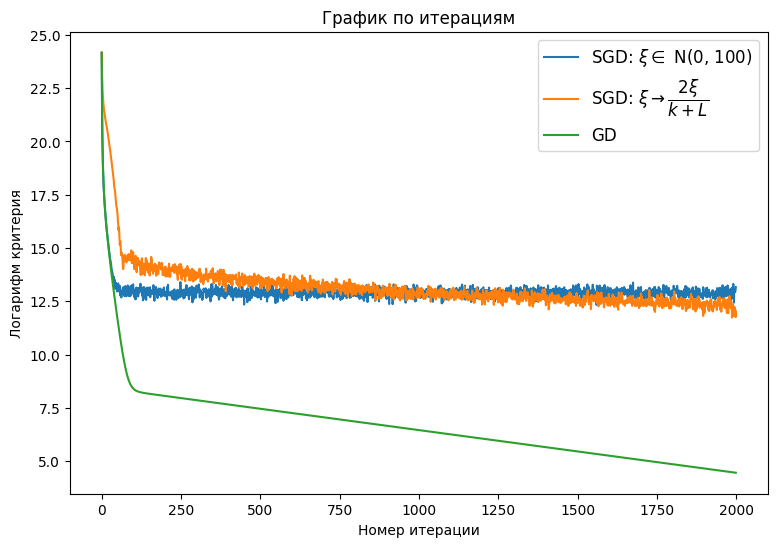

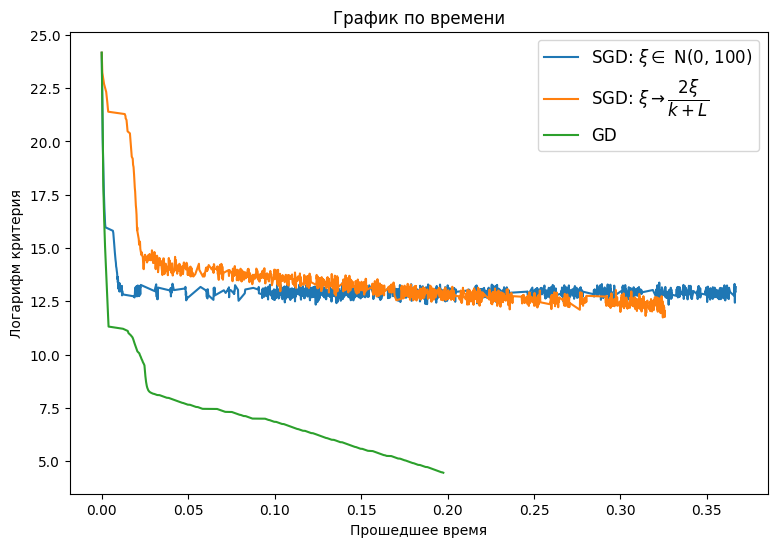

In [207]:
lab = [r'SGD: $\xi \in$ N(0, 100)', r'SGD: $\xi \rightarrow \dfrac{2\xi}{k+L}$', 'GD']
risovach(times=[times1, times2, times3], errs=[errs1, errs2, errs3], labels=lab)

Приведенный в условии задачи метод не сходится из-за стохастической части. Новый SGD' сходится, но ощутимо медленнее базового GD. 

__(б)__ На семинаре обсуждались способы борьбы со "стохастичностью" сходимости градиентного спуска. В частности, мы затронули использование уменьшающегося шага (смотри, например, Теорему 5 из [работы](https://arxiv.org/pdf/1907.04232.pdf)), а также использование батчирования (в нашем случае это просто замена: $\xi^k \to \frac{1}{b} \sum\limits_{i=1}^b \xi^k_i$, где $\xi^k_i \in \mathcal{N}(0, 100)$ и независимы). Реализуйте эти модификации (для батчирования возьмите $b = 10 , 100$). Добавьте полученные результаты на график сходимости из пункта (а). Постройте также график сходимости, где по оси $x$ будет не количество итераций, а количество генераций $\xi^k_i$ (количество вызовов стохастического градиента).

In [189]:
batch1, batch2 = 10, 50

x4, f4, times4, errs4 = method(x0, step=sgd_step1, gamma=gamma_const, b=batch1, iters=iters)
x5, f5, times5, errs5 = method(x0, step=sgd_step1, gamma=gamma_const, b=batch2, iters=iters)

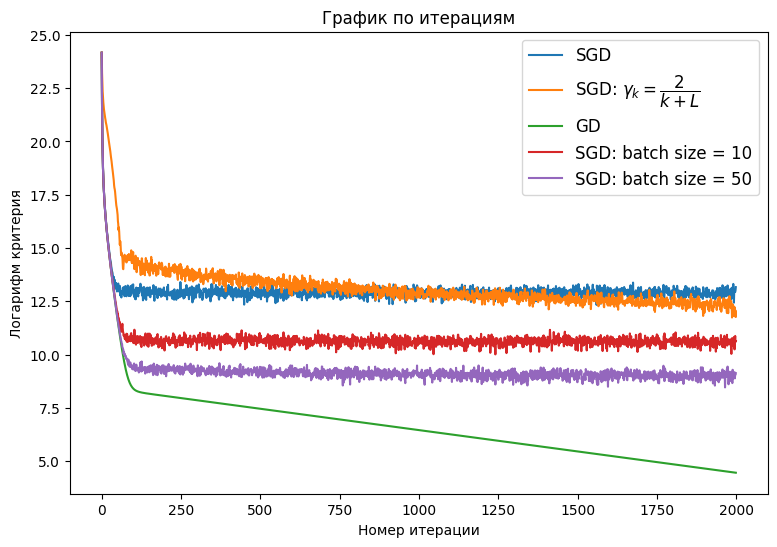

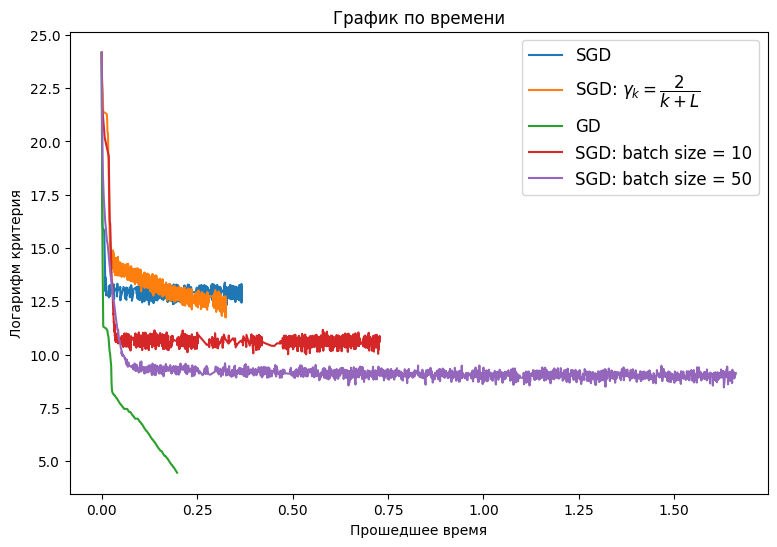

In [190]:
# r'SGD: $\gamma = \dfrac{1}{k+100}$'
lab = ['SGD', r'SGD: $\gamma_k = \dfrac{2}{k+L}$', 'GD', r'SGD: batch size = ' + str(batch1), r'SGD: batch size = ' + str(batch2)]
risovach(times=[times1, times2, times3, times4, times5], errs=[errs1, errs2, errs3, errs4, errs5], labels=lab)

1. Метод с уменьшающимся шагом сходится, но очень медленно, все еще значительно отставая от GD. 

2. Батчирование лишь отложило наш выход на плато сходимости: матожидание нормы усредненной центрированной величины ближе к нулю, чем не у усредненной. 

P.s. график сходимости по количеству генераций $\xi^k_i$ есть график по итерациям, растянутый в batch size раз; график сходимости по времени неплохо отражает происходящее.

## Задача 2

Рассмотрим задачу логистической регрессии на датасете mushrooms с $\ell_2$-регуляризацией (коэффициент регуляризации равен $\frac{L}{1000}$). Как мы знаем, эта задача имеет вид конечной суммы:
\begin{equation}
\min_{w \in \mathbb{R}^d} f(w) := \frac{1}{n} \sum\limits_{j=1}^n f_j(w) := \frac{1}{n} \sum\limits_{j=1}^n \left[\frac{1}{b} \sum\limits_{i=1}^b f_{ji}(w)\right] := \frac{1}{n} \sum\limits_{j=1}^n \left[\frac{1}{b} \sum\limits_{i=1}^b l (g(w, x_i), y_i)\right],
\end{equation}
где $nb = N$ - полный размер выборки. Решите данную задачу с помощью SGD, SAGA (секция А.5 из [работы](https://arxiv.org/pdf/1905.11261.pdf)), SVRG (секция А.9 из [работы](https://arxiv.org/pdf/1905.11261.pdf)) и SARAH ([работа](https://arxiv.org/pdf/1703.00102.pdf)). 

__(а)__ Оцените $\mu$ и $L$ для данной задачи. Обратите внимание, что теория для SAGA, SVRG, SARAH предполагает, что $L$ - это константа Липшица градиентов $\nabla f_j$. 

$f =  \dfrac{1}{n}\sum\limits_{i=1}^n \ln(1+\exp(-w^Tx_iy_i))$

$\nabla f =  -\dfrac{1}{n}\sum\limits_{i=1}^n \dfrac{1}{1 + e^{w^Tx_iy_i}}x_iy_i$

$\nabla^2 f = \dfrac{1}{n}\sum\limits_{i=1}^n \dfrac{e^{w^Tx_iy_i}}{(1 + e^{w^Tx_iy_i})^2}(x_ix_i^T) y_i^2$

In [47]:
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split 

dataset = "mushrooms.txt"
data = load_svmlight_file(dataset)
X, y = data[0].toarray(), data[1]

# {1,2} -> {-1, 1}
y = 2 * y - 3

# N - число наблюдений, d - признаков
N, d = X.shape

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1999)
n_train = X_train.shape[0]

In [49]:
from numba import jit

@jit
def f_i(w, i):
    return np.log(1 + np.exp(-y_train[i] * (w.T @ X_train[i])))

@jit
def grad_i(w, i):
    return -y_train[i] / (1 + np.exp(y_train[i] * (w.T @ X_train[i]))) * X_train[i]

@jit
def f(w):
    ans = 0
    for i in range(n_train):
        ans += f_i(w, i)
    return ans / n_train

@jit
def grad(w):
    ans = np.zeros(d)
    for i in range(n_train):
        ans += grad_i(w, i)
    return ans / n_train

Оценим $\mu$ и $L$. Для этого можем положить $\omega = 0$, вычислить $\mu, L$ для каждой отдельно взятой $f_i = \ln (1+\exp (-\omega^Tx_iy_i))$ и взять из них минимум и максимум соответственно.

In [50]:
L = 0
mu = 100000

for i in range(n_train):

    hessian_i = (X_train[i].reshape((d, 1)) @ X_train[i].reshape((1, d))) / 4
    eigvals = np.linalg.eigvals(hessian_i)
    L_i = np.amax(eigvals)
    mu_i = np.amin(eigvals)

    if L_i > L:
        L = L_i
    if mu_i < mu:
        mu = mu_i

L, mu

((5.25+0j), (-3.544983541696406e-17+0j))

In [51]:
from sklearn.metrics import accuracy_score

L = 5.25
mu = 0
x0 = np.random.uniform(low=-L/10, high=L/10, size=(d,))

__(б)__ Реализуйте SGD, SAGA, SVRG, SARAH для задачи логистической регресии из $n$ слагаемых, где каждое слагаемое так же имеет виды суммы размеры $b$. Каким надо взять $b$? Почему? Что об этом говорит теория? Как будете выбирать шаг и другие параметры методов?

In [142]:
def risovach(grads, times, errs, labels, title='', accuracy=False, accs=[]):

    plt.figure(figsize=(10, 7))
    for g, e, l in zip(grads, errs, labels):
        plt.plot(g, np.log(e), label=l)
    plt.xlabel("Кол-во вызовов градиента")
    plt.ylabel("Логарифм критерия")
    plt.title(title + 'Вызовы градиента. Критерий')
    plt.legend(fontsize=12)
    plt.show()

    plt.figure(figsize=(10, 7))
    for t, e, l in zip(times, errs, labels):
        plt.plot(t, np.log(e), label=l)
    plt.xlabel("Прошедшее время")
    plt.ylabel("Логарифм критерия")
    plt.title(title + 'Время. Критерий')
    plt.legend(fontsize=12)
    plt.show()

    if accuracy == True:
        plt.figure(figsize=(10, 7))
        for g, a, l in zip(grads, accs, labels):
            plt.plot(g[::10], a, label=l)
        plt.xlabel("Кол-во вызовов градиента")
        plt.ylabel("Точность на тесте")
        plt.title(title + 'Вызовы градиента. Точность')
        plt.legend(fontsize=12)
        plt.show()

        plt.figure(figsize=(10, 7))
        for t, a, l in zip(times, accs, labels):
            plt.plot(t[::10], a, label=l)
        plt.xlabel("Прошедшее время")
        plt.ylabel("Точность на тесте")
        plt.title(title + 'Время. Точность')
        plt.legend(fontsize=12)
        plt.show()

In [277]:
def error(x):
    return np.linalg.norm(grad(x), ord=2)**2

# точность будем записывать каждый 10й шаг

def sgd(x0, gamma, b=1, iters=1000):
    x = x0
    x_vals = [x]
    grad_cnt = 0
    grads = [grad_cnt]
    times = [0.]
    errs = [error(x)]
    acc = [accuracy_score(y_test, np.around(2 / (1 + np.exp(- X_test @ x))) - 1)]

    start = time.time()

    for i in range(1, iters):
        
        stoch_grad = np.zeros(d)
        for k in range(b):
            index = np.random.randint(low=0, high=n_train)
            stoch_grad += grad_i(x, index)
        stoch_grad = stoch_grad / b

        x = x - gamma * stoch_grad

        x_vals.append(x)
        grad_cnt += b
        grads.append(grad_cnt)
        times.append(time.time() - start)
        errs.append(error(x))
        if i % 10 == 0:
            acc.append(accuracy_score(y_test, np.around(2 / (1 + np.exp(- X_test @ x))) - 1))

    return x_vals, grads, times, errs, acc

def saga(x0, gamma, b=1, iters=1000):
    x = x0
    x_vals = [x]
    grad_cnt = 0
    grads = [grad_cnt]
    times = [0.]
    errs = [error(x)]
    acc = [accuracy_score(y_test, np.around(2 / (1 + np.exp(- X_test @ x))) - 1)]

    start = time.time()

    y = [grad_i(x, i) for i in range(n_train)]
    g = grad(x)

    for i in range(1, iters):

        x = x - gamma * g

        for k in range(b):
            index = np.random.randint(low=0, high=n_train)
            tmp1 = y[index] # old
            tmp2 = grad_i(x, index) # new
            y[index] = tmp2
            g = g + (tmp2 - tmp1)/n_train

        x_vals.append(x)
        grad_cnt += b
        grads.append(grad_cnt)
        times.append(time.time() - start)
        errs.append(error(x))
        if i % 10 == 0:
            acc.append(accuracy_score(y_test, np.around(2 / (1 + np.exp(- X_test @ x))) - 1))

    return x_vals, grads, times, errs, acc


def svrg(x0, gamma, b=1, iters=1000, m=50):
    
    x = x0
    y = x0
    x_vals = [x]
    grad_cnt = 0
    grads = [grad_cnt]
    times = [0.]
    errs = [error(x)]
    acc = [accuracy_score(y_test, np.around(2 / (1 + np.exp(- X_test @ x))) - 1)]

    start_time = time.time()
    
    np.random.seed(2)
    
    for i in range(iters// m):
        
        g = grad(y)
        summa = 0
        grad_cnt += n_train
        
        for j in range(m):
            
            for _ in range(b):
                i = np.random.randint(n_train)
                g = (grad_i(x, i) - grad_i(y, i))/n_train + g
                
            x = x - gamma * g
            summa += x

            grad_cnt += 2*b
            grads.append(grad_cnt)
            errs.append(error(x))
            times.append(time.time() - start_time)
            if j % 10 == 0:
                acc.append(accuracy_score(y_test, np.around(2 / (1 + np.exp(- X_test @ x))) - 1))
            
        y = 1 / m * summa

    return x_vals, grads, times, errs, acc

In [227]:
iters = 1000

x_sgd_5, grads_sgd_5, times_sgd_5, errs_sgd_5, acc_sgd_5 = sgd(x0=x0, gamma=1/L, b=5, iters=iters)
x_sgd_20, grads_sgd_20, times_sgd_20, errs_sgd_20, acc_sgd_20 = sgd(x0=x0, gamma=2/L, b=20, iters=iters)
x_sgd_100, grads_sgd_100, times_sgd_100, errs_sgd_100, acc_sgd_100 = sgd(x0=x0, gamma=5/L, b=100, iters=iters)
x_sgd_300, grads_sgd_300, times_sgd_300, errs_sgd_300, acc_sgd_300 = sgd(x0=x0, gamma=15/L, b=300, iters=iters)

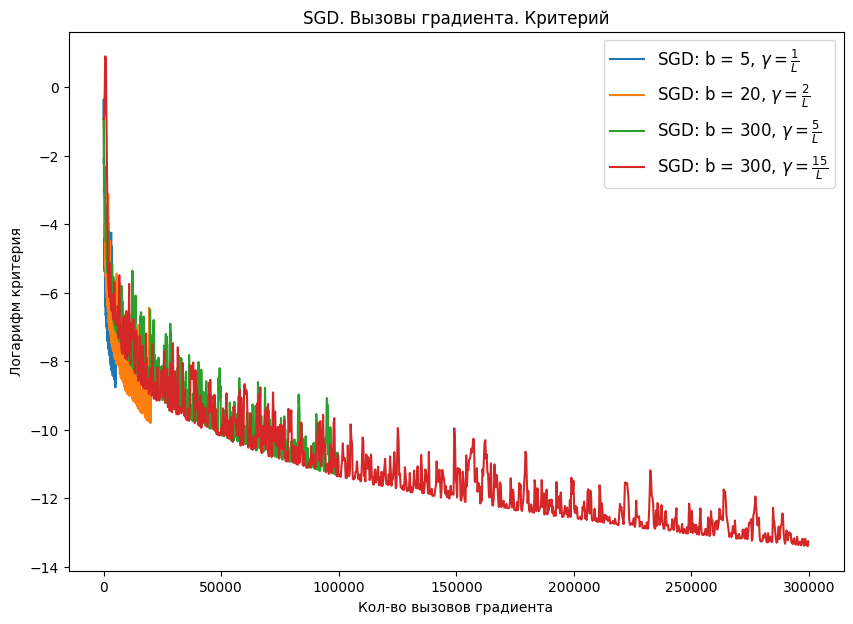

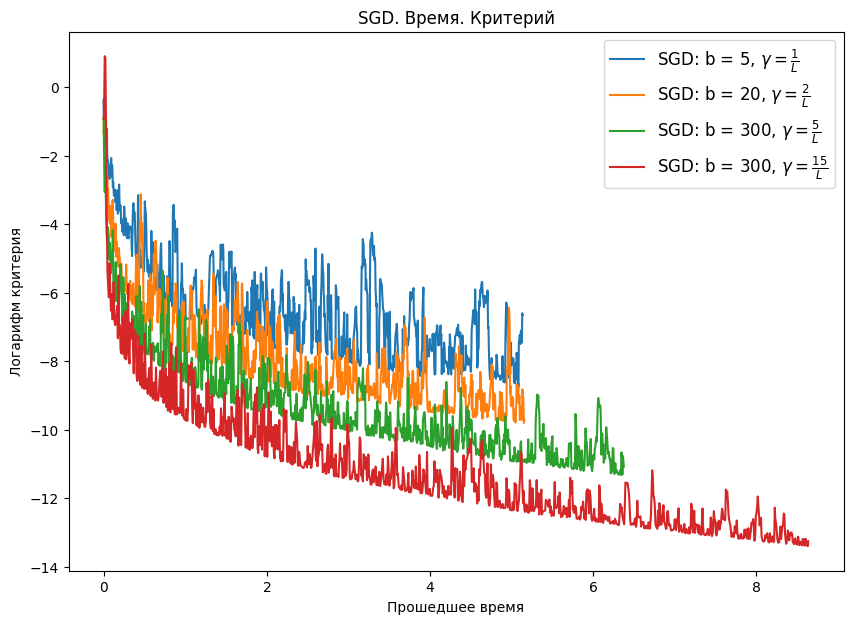

In [228]:
risovach(grads = [grads_sgd_5, grads_sgd_20, grads_sgd_100, grads_sgd_300],
         times=[times_sgd_5, times_sgd_20, times_sgd_100, times_sgd_300], 
         errs=[errs_sgd_5, errs_sgd_20, errs_sgd_100, errs_sgd_300], 
         labels=[r'SGD: b = 5, $\gamma = \frac{1}{L}$', r'SGD: b = 20, $\gamma = \frac{2}{L}$', 
                 r'SGD: b = 300, $\gamma = \frac{5}{L}$', r'SGD: b = 300, $\gamma = \frac{15}{L}$'],
                 title='SGD. ')

Метод сходится. Увеличение размера батча делает сходимость более гладкой. Увеличение шага увеличивает осцилляции, но улучшает сходимость. Лучше всего увеличение шага сочетается с большим размером батча - его большой шаг колбасит меньше всего.

По количеству вызовов градиента победил спуск с наименьшим батчем. Он не победил по времени, по скольку под коробкой дополнительно считается полный градмент.

В качестве оптимальных параметров возьмем batch = 5, $\gamma = \frac{1}{L}$

In [246]:
iters = 1000

x_saga_5, grads_saga_5, times_saga_5, errs_saga_5, acc_saga_5 = saga(x0=x0, gamma=1/L, b=5, iters=iters)
x_saga_20, grads_saga_20, times_saga_20, errs_saga_20, acc_saga_20 = saga(x0=x0, gamma=2/L, b=20, iters=iters)
x_saga_100, grads_saga_100, times_saga_100, errs_saga_100, acc_saga_100 = saga(x0=x0, gamma=5/L, b=100, iters=iters)
x_saga_300, grads_saga_300, times_saga_300, errs_saga_300, acc_saga_300 = saga(x0=x0, gamma=15/L, b=300, iters=iters)

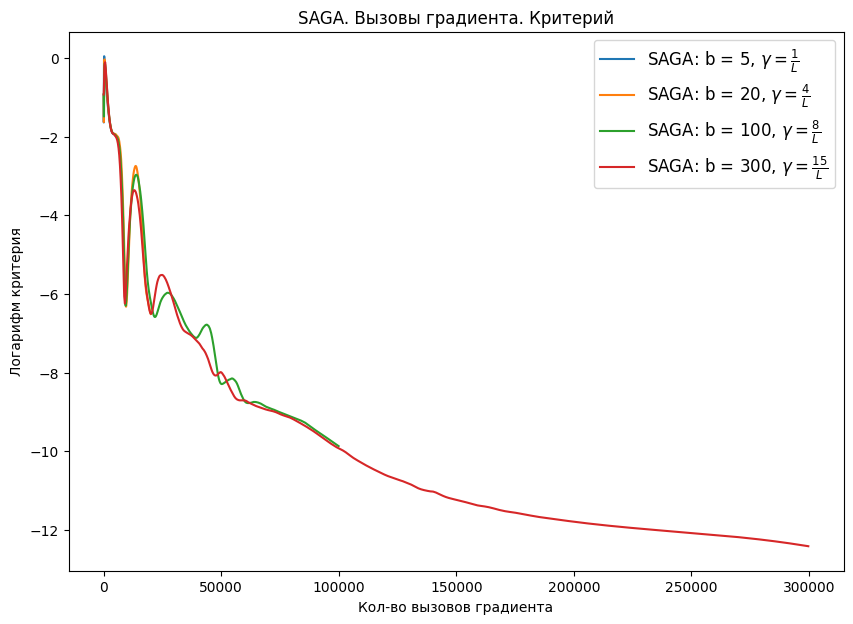

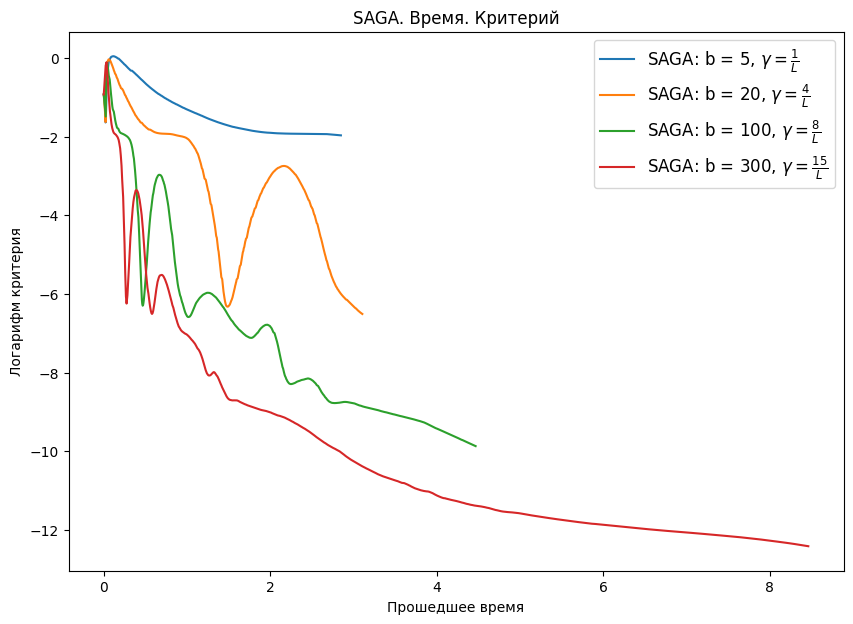

In [247]:
risovach(grads=[grads_saga_5, grads_saga_20, grads_saga_100, grads_saga_300],
         times=[times_saga_5, times_saga_20, times_saga_100, times_saga_300], 
         errs=[errs_saga_5, errs_saga_20, errs_saga_100, errs_saga_300], 
         labels=[r'SAGA: b = 5, $\gamma = \frac{1}{L}$', r'SAGA: b = 20, $\gamma = \frac{4}{L}$', 
                 r'SAGA: b = 100, $\gamma = \frac{8}{L}$', r'SAGA: b = 300, $\gamma = \frac{15}{L}$'],
                 title='SAGA. ')

SAGA намного хуже чувствует себя при мало размере батча, чем SGD. По вызовам градиента запуски при разных батчах отработали почти одинаково.

В качестве оптимальных возьмем batch = 300, $\gamma = \frac{15}{L}$

In [285]:
iters = 1000

x_svrg_1, grads_svrg_1, times_svrg_1, errs_svrg_1, acc_svrg_1 = svrg(x0=x0, gamma=1/L, b=1, iters=iters)
x_svrg_10, grads_svrg_10, times_svrg_10, errs_svrg_10, acc_svrg_10 = svrg(x0=x0, gamma=2/L, b=10, iters=iters)
x_svrg_50, grads_svrg_50, times_svrg_50, errs_svrg_50, acc_svrg_50 = svrg(x0=x0, gamma=4/L, b=50, iters=iters)
x_svrg_200, grads_svrg_200, times_svrg_200, errs_svrg_200, acc_svrg_200 = svrg(x0=x0, gamma=8/L, b=200, iters=iters)

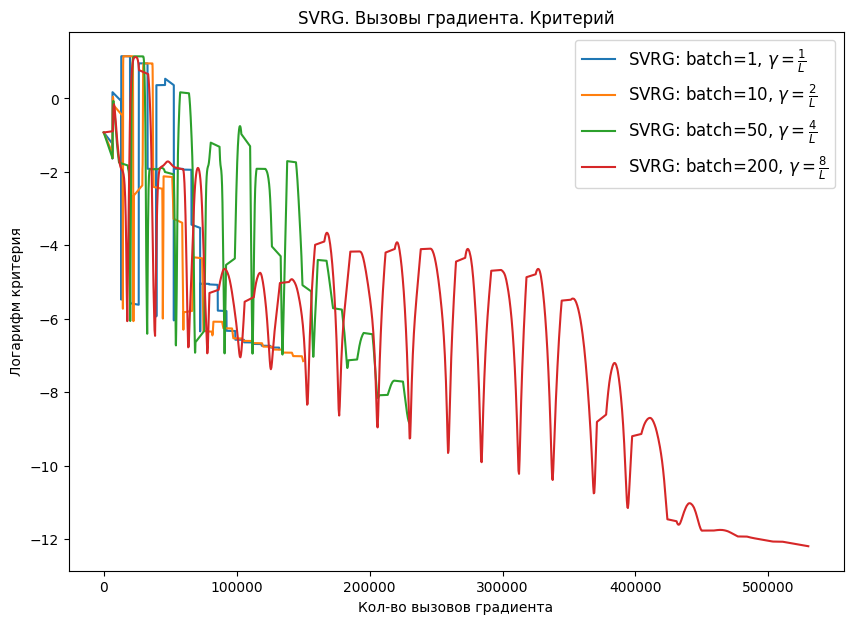

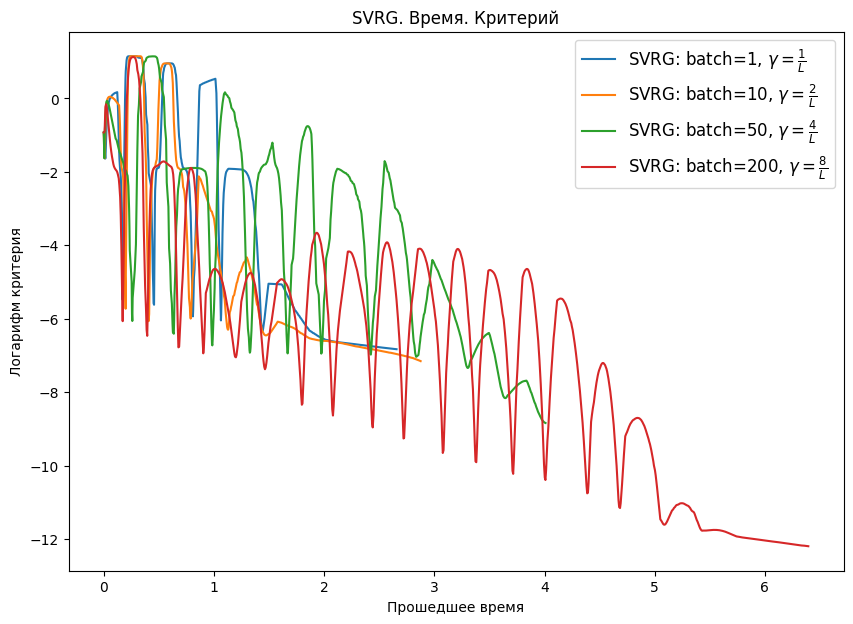

In [286]:
risovach(grads = [grads_svrg_1, grads_svrg_10, grads_svrg_50, grads_svrg_200],
         times=[times_svrg_1, times_svrg_10, times_svrg_50, times_svrg_200], 
         errs=[errs_svrg_1, errs_svrg_10, errs_svrg_50, errs_svrg_200],
         labels=[r'SVRG: batch=1, $\gamma=\frac{1}{L}$', r'SVRG: batch=10, $\gamma=\frac{2}{L}$',
                 r'SVRG: batch=50, $\gamma=\frac{4}{L}$', r'SVRG: batch=200, $\gamma=\frac{8}{L}$'],
         title='SVRG. ')

В качестве оптимальных возьмем batch=200, $\gamma = \frac{8}{L}$. Снова при большом батче можем позволить себе большой шаг, за счет чего скорость сходимости и имеется.

In [202]:
def sarah():
    pass

__(в)__ Постройте графики сравнения всех методов: по оси $x$ используйте время или количество подсчетов $\nabla f_{ji}$, по оси $y$ - $\|\nabla f(w^k)\|$ или точность на тесте. Таким образом, всего 4 графика. Сделайте сравнение и вывод.

In [289]:
x_sgd, grads_sgd, times_sgd, errs_sgd, acc_sgd = sgd(x0=x0, gamma=1/L, b=5, iters=2000)
x_saga, grads_saga, times_saga, errs_saga, acc_saga = saga(x0=x0, gamma=15/L, b=300, iters=500)
x_svrg, grads_svrg, times_svrg, errs_svrg, acc_svrg = svrg(x0=x0, gamma=8/L, b=200, iters=1000)

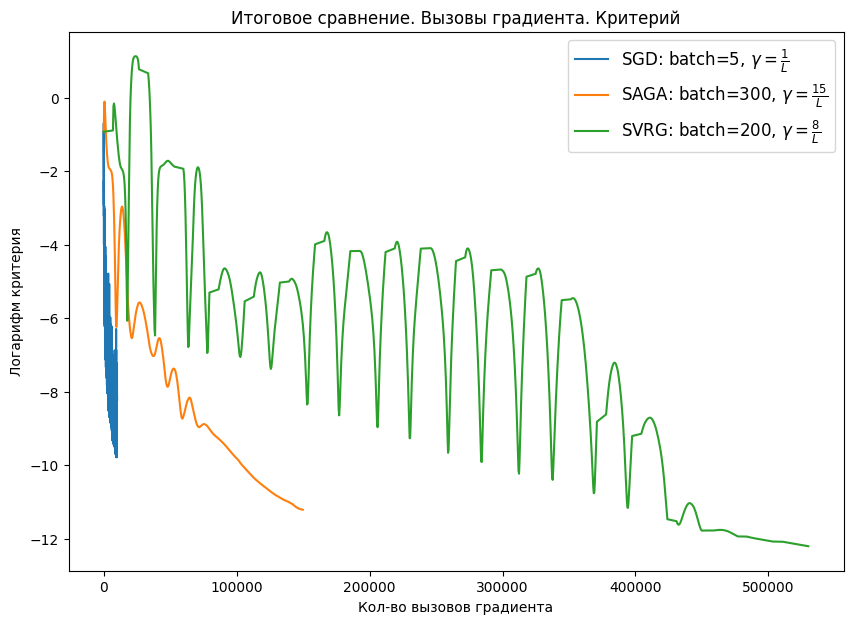

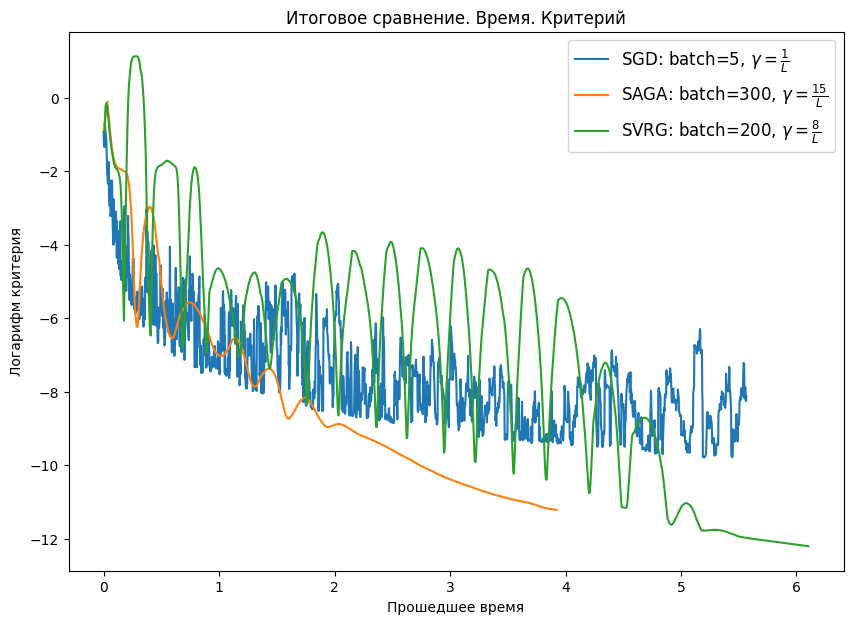

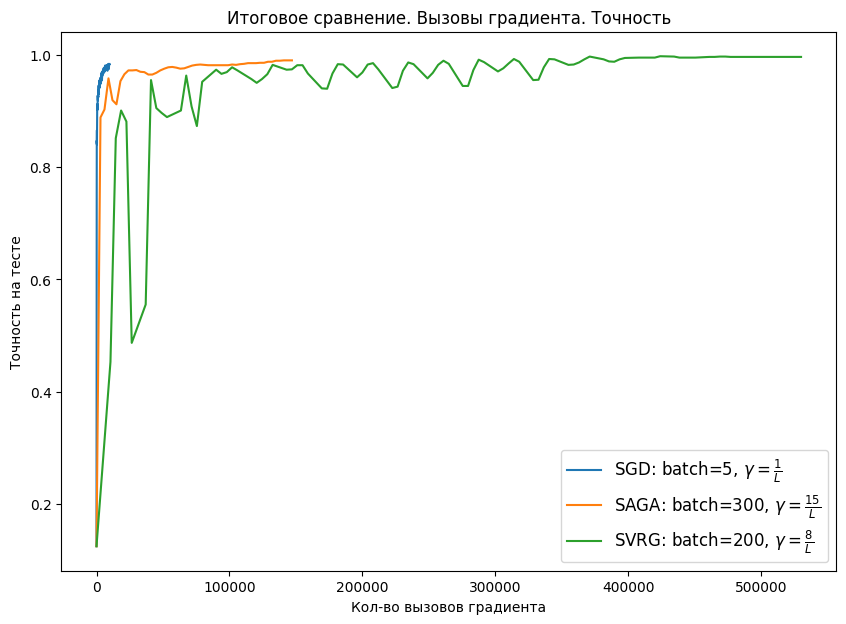

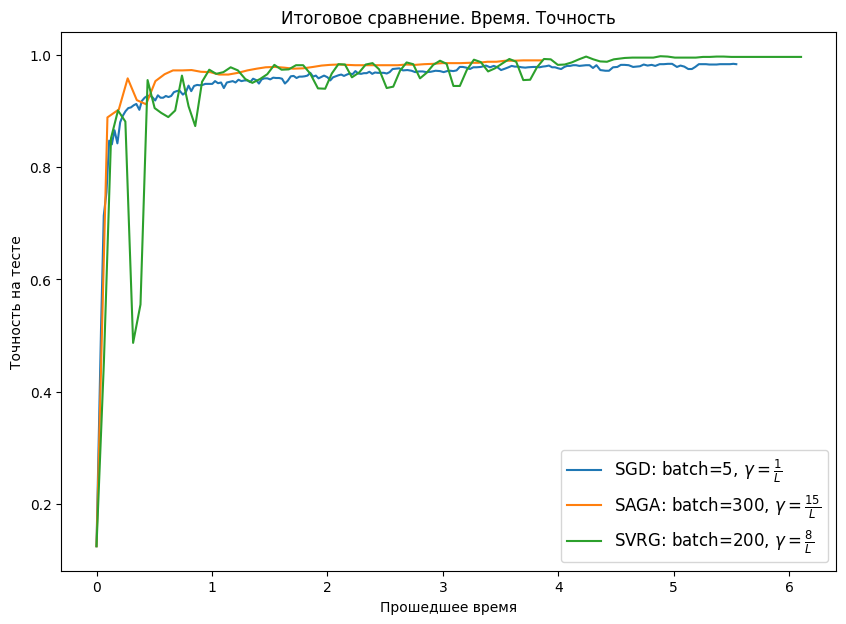

In [290]:
risovach(grads=[grads_sgd, grads_saga, grads_svrg],
         times=[times_sgd, times_saga, times_svrg],
         errs=[errs_sgd, errs_saga, errs_svrg],
         labels=[r'SGD: batch=5, $\gamma = \frac{1}{L}$', r'SAGA: batch=300, $\gamma = \frac{15}{L}$',
                 r'SVRG: batch=200, $\gamma=\frac{8}{L}$'],
         title='Итоговое сравнение. ', accuracy=True,
         accs=[acc_sgd, acc_saga, acc_svrg])

__Бонусные пункты__

__(г)__ Методы SGD, SAGA, SVRG, SARAH, которые мы рассматривали, предполагают случайный выбор индекса на каждой итерации. Но между тем, на практике обычно делают по-другому и просто последовательно меняют $i_k$ от $1$ до $n$ (а потом заново). В [работе](https://arxiv.org/abs/2006.05988) изучаются такие подходы. Реализуйте Random Reshuffling и Shuffle Once для SGD и SARAH. Сравните новые алгоритмы со старыми версиями SGD и SARAH из пунктов (б) и (в).

In [205]:
#ответ

__(д)__ Методы SVRG и SARAH имеют loopless версии: L-SVRG (секция А.10 из [работы](https://arxiv.org/pdf/1905.11261.pdf) и PAGE ([работа](https://proceedings.mlr.press/v139/li21a.html)), соотвественно. Реализуйте их. Как будете выбирать вероятности в этих алгоритмах? Сравните новые алгоритмы со старыми версиями SVRG и SARAH из пунктов (б) и (в).

In [206]:
#ответ